# Recurrent neural network and dynamical system analysis

In this notebook, we will analyze the dynamics of a recurrent neural network (RNN) using the tools of dynamical systems theory. We will use the RNN to solve a simple task, and then we will analyze the dynamics of the RNN to understand how it solves the task. We will use the Lorenz system as a benchmark to compare the dynamics of the RNN. The Lorenz system is a well-known dynamical system that exhibits chaotic behavior. We will show that the dynamics of the RNN are similar to the dynamics of the Lorenz system, which suggests that the RNN is capable of complex behavior.

## Install necessary packages for data generation

```bash
git clone https://github.com/neurogym/neurogym.git
cd neurogym
pip install -e .
```

## Import necessary packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA

import neurogym as ngym

## Defining a cognitive task

d:\Anaconda3\envs\ml\lib\site-packages\gym\utils\passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
d:\Anaconda3\envs\ml\lib\site-packages\gym\utils\passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
d:\Anaconda3\envs\ml\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


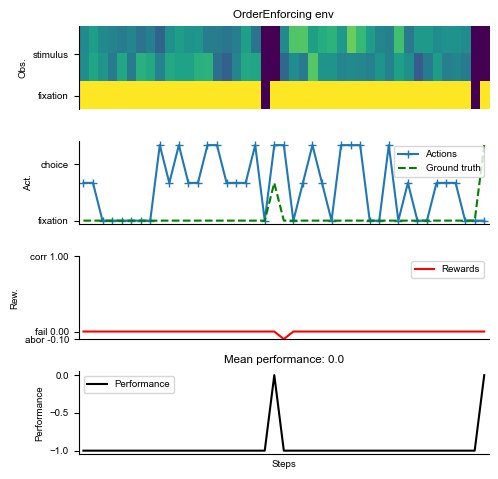

In [41]:
# Environment
task = 'PerceptualDecisionMaking-v0'
kwargs = {'dt': 100}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

## Define a continuous-time RNN

Here we will define a continuous-time RNN but discretize it in time using the Euler method.
\begin{align}
    \tau \frac{d\mathbf{r}}{dt} = -\mathbf{r}(t) + f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r).
\end{align}

This continuous-time system can then be discretized using the Euler method with a time step of $\Delta t$, 
\begin{align}
    \mathbf{r}(t+\Delta t) = \mathbf{r}(t) + \Delta \mathbf{r} = \mathbf{r}(t) + \frac{\Delta t}{\tau}[-\mathbf{r}(t) + f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r)].
\end{align}

In [ ]:
class CTRNN(nn.Module):
    """Continuous-time RNN.

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size), network input
        hidden: (batch, hidden_size), initial hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        pre_activation = self.input2h(input) + self.h2h(hidden)
        new_hidden = torch.sigmoid(pre_activation)
        return new_hidden

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        output = torch.stack(output, dim=0)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Continuous time RNN
        self.rnn = CTRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        out = self.fc(rnn_activity)
        return out, rnn_activity

+ once tried using Poisson to replace the sigmoid function, but it didn't work well. So I still will use the sigmoid function here.

In [43]:
def recurrence(self, input, hidden):
    pre_activation = self.input2h(input) + self.h2h(hidden)
    pre_activation = torch.clamp(pre_activation, max=10)  # Avoiding too large values for exp
    rate = torch.exp(pre_activation)
    h_new = torch.poisson(rate * self.alpha + hidden * self.oneminusalpha)
    return h_new

### Define the Loss function

Here we will use the mutual information between the input and the output of the RNN as the loss function. The mutual information is a measure of the amount of information that the input and the output share.

The mutual information between two random variables $X$ and $Y$ is defined as
\begin{align}
    I(X;Y) = \sum_{x,y} p(x,y) \log \left( \frac{p(x,y)}{p(x)p(y)} \right),
\end{align}
where $p(x,y)$ is the joint probability distribution of $X$ and $Y$, and $p(x)$ and $p(y)$ are the marginal probability distributions of $X$ and $Y$, respectively.


In [44]:
class MutualInformationLoss(nn.Module):
    def __init__(self, standard_loss=nn.CrossEntropyLoss(), beta=0.1):
        super(MutualInformationLoss, self).__init__()
        self.standard_loss = standard_loss
        self.beta = beta

    def forward(self, outputs, targets):
        loss = self.standard_loss(outputs, targets)
        # Placeholder for mutual information calculation
        # Assume mutual_information is a scalar for simplicity here
        mutual_information = torch.tensor(0.01, device=outputs.device)
        # Expand mutual_information to match the batch size of outputs
        mutual_information = mutual_information.expand_as(loss)
        # Integrate mutual information into the loss
        loss -= self.beta * mutual_information
        return loss


## Train the RNN on the decision-making task

In [45]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the network and print information
hidden_size = 64
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)
net.to(device)  # Move the network to the GPU
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.01)
# Use mutual information loss to replace cross entropy loss
criterion = MutualInformationLoss(nn.CrossEntropyLoss(), beta=0.1).to(device)

running_loss = 0
running_acc = 0

# Training loop
for i in range(1000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)

    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    output, _ = net(inputs)
    output = output.view(-1, output_size)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()    # Does the update

    running_loss += loss.item()
    if i % 100 == 99:
        running_loss /= 100
        print('Step {}, Loss {:0.4f}'.format(i+1, running_loss))
        running_loss = 0

Using device: cuda
RNNNet(
  (rnn): CTRNN(
    (input2h): Linear(in_features=3, out_features=64, bias=True)
    (h2h): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc): Linear(in_features=64, out_features=3, bias=True)
)
Step 100, Loss 0.2139
Step 200, Loss 0.0716
Step 300, Loss 0.0363
Step 400, Loss 0.0327
Step 500, Loss 0.0316
Step 600, Loss 0.0309
Step 700, Loss 0.0237
Step 800, Loss 0.0151
Step 900, Loss 0.0149
Step 1000, Loss 0.0145


### Visualize the dynamics of the RNN

It makes sense to visualize the dynamics of the RNN to understand how it solves the task. We can do this by plotting the activity of the RNN over time.

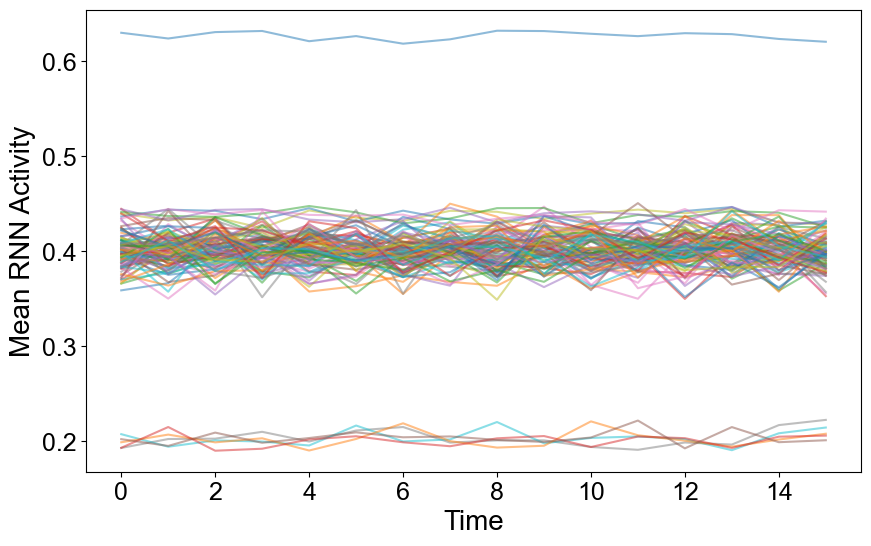

In [63]:
# Visualize the dynamics of the RNN
inputs, labels = dataset()
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)

# Forward pass
output, rnn_activity = net(inputs)
output = output.view(-1, output_size)

# Convert to numpy array and move to CPU if necessary
rnn_activity_np = rnn_activity.detach().cpu().numpy()

# Compute the mean activity over the hidden units (last dimension)
mean_activity = np.mean(rnn_activity_np, axis=2)

# Plot the mean activity over time for each sequence in the batch
plt.figure(figsize=(10, 6))
for i in range(mean_activity.shape[0]):  # Loop over batch size
    plt.plot(mean_activity[i], alpha=0.5)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Mean RNN Activity', fontsize=20)
# plt.title('RNN Dynamics (Mean Activity Over Hidden Units)')
plt.show()

### Visualize the PCA of the RNN

Principal component analysis (PCA) is a technique used to reduce the dimensionality of a dataset. We can use PCA to visualize the dynamics of the RNN in a lower-dimensional space.

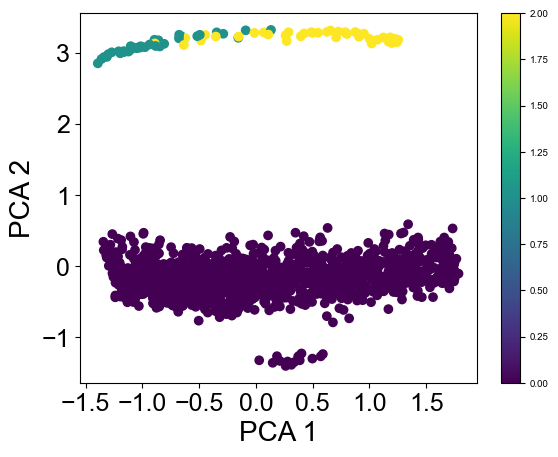

In [64]:
# Visualize the PCA of the RNN activity
pca = PCA(n_components=2)

# Fit the PCA model
pca.fit(rnn_activity.detach().cpu().numpy().reshape(-1, hidden_size))  # Detach here as well

# Transform the RNN activity
rnn_pca = pca.transform(rnn_activity.detach().cpu().numpy().reshape(-1, hidden_size))  # And here

# Plot the PCA of the RNN activity
plt.figure()
plt.scatter(rnn_pca[:, 0], rnn_pca[:, 1], c=labels.cpu().numpy().flatten())
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('PCA 1', fontsize=20)
plt.ylabel('PCA 2', fontsize=20)
#plt.title('PCA of RNN Activity')
plt.colorbar()
plt.show()

## Evaluate the trained network

### Compute the average loss and accuracy

In [48]:
# Set the model to evaluation mode
net.eval()

# Initialize test metrics
total_loss = 0
correct = 0
total = 0
all_labels = []
all_scores = []
all_outputs = []  # Collect all outputs for correlation analysis

# No gradient calculation
num_trials = 100
with torch.no_grad():
    for i in range(num_trials):
        env.new_trial()
        ob, gt = env.ob, env.gt
        ob = ob[:, np.newaxis, :]  # Add batch axis to fit network input
        inputs = torch.from_numpy(ob).type(torch.float).to(device)
        labels = torch.from_numpy(gt.flatten()).type(torch.long).to(device)

        # Forward pass
        output, _ = net(inputs)
        output = output.view(-1, output_size)

        # Compute loss
        loss = criterion(output, labels)
        total_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect all labels and prediction scores
        all_labels.extend(labels.cpu().numpy())
        all_scores.extend(output.cpu().numpy())
        all_outputs.extend(predicted.cpu().numpy())

# Compute average loss and accuracy
avg_loss = total_loss / 100
accuracy = 100 * correct / total

print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

Test Loss: 0.0151, Test Accuracy: 99.32%


### Compute the confusion matrix

The confusion matrix is a table that is often used to describe the performance of a classification model. The confusion matrix shows the number of true positives, true negatives, false positives, and false negatives.

The confusion matrix is defined as
\begin{align}
    \begin{bmatrix}
        TP & FP \\
        FN & TN
    \end{bmatrix},
\end{align}
where $TP$ is the number of true positives, $FP$ is the number of false positives, $FN$ is the number of false negatives, and $TN$ is the number of true negatives.

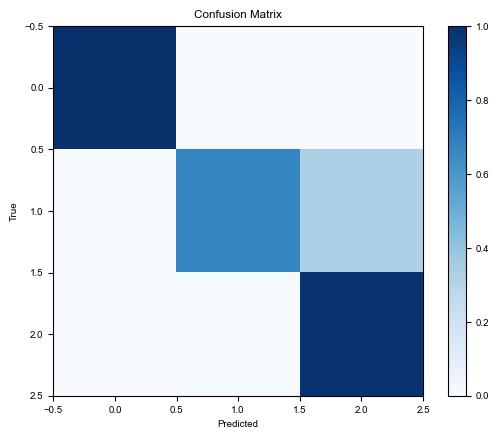

In [ ]:
# Compute the confusion matrix
confusion_matrix = np.zeros((output_size, output_size))
for i in range(len(all_labels)-1):
    confusion_matrix[all_labels[i], all_outputs[i]] += 1

# Normalize the confusion matrix
confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure()
plt.imshow(confusion_matrix, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Compute the ROC curve

The receiver operating characteristic (ROC) curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

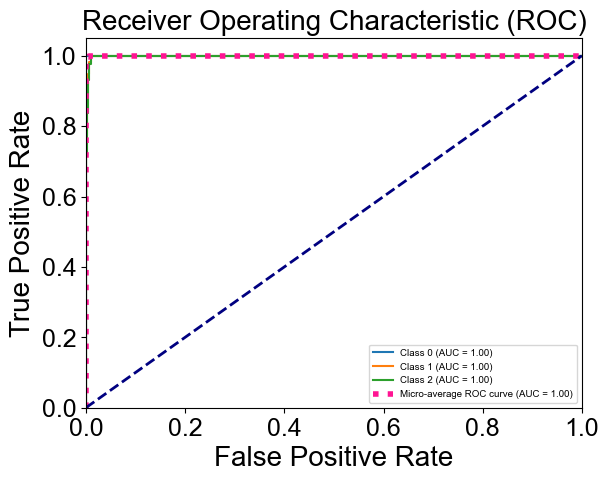

In [66]:
# Convert labels to binary format
n_classes = output_size
all_labels = label_binarize(all_labels, classes=np.arange(n_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], np.array(all_scores)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), np.array(all_scores).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})', color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=20)
plt.legend(loc="lower right")
plt.show()

### Compute the correlation matrix

The correlation matrix is a table that shows the correlation coefficients between pairs of variables in a dataset.

In [51]:
def calculate_correlation_matrix(outputs):
    correlation_matrix = np.corrcoef(outputs.T)
    return correlation_matrix

# do significance test
def significance_test(correlation_matrix, num_neurons):
    p_values = np.ones_like(correlation_matrix)
    for i in range(num_neurons):
        for j in range(i + 1, num_neurons):
            corr = correlation_matrix[i, j]
            # calculate p-value
            r = np.random.randn(100, num_neurons)  # random data
            random_corr_matrix = np.corrcoef(r.T)  # correlation matrix of random data
            p_value = (np.abs(random_corr_matrix) >= np.abs(corr)).mean()
            p_values[i, j] = p_values[j, i] = p_value
    return p_values

# Calculate correlation matrix and p-values
correlation_matrix = calculate_correlation_matrix(np.array(all_scores))
output_size = all_scores[0].shape[0]  # Number of output neurons
p_values = significance_test(correlation_matrix, output_size)

# Print correlation matrix and p-values
print("Correlation Matrix:")
print(correlation_matrix)
print("P-Values:")
print(p_values)

Correlation Matrix:
[[ 1.         -0.77141044 -0.9047488 ]
 [-0.77141044  1.          0.43102256]
 [-0.9047488   0.43102256  1.        ]]
P-Values:
[[1.         0.33333333 0.33333333]
 [0.33333333 1.         0.33333333]
 [0.33333333 0.33333333 1.        ]]


## Dynamical system analysis

### Search for approximate fixed points
Here we search for approximate fixed points and visualize them in the same PC space. In a generic dynamical system,
\begin{align}
    \frac{d\mathbf{x}}{dt} = F(\mathbf{x}),
\end{align}
We can search for fixed points by doing the optimization
\begin{align}
    \mathrm{argmin}_{\mathbf{x}} |F(\mathbf{x})|^2.
\end{align}

In [55]:
# Freeze parameters in the recurrent network
for param in net.parameters():
    param.requires_grad = False

batch_size = 64

# Inputs should be the 0-coherence mean input during stimulus period
# This will be task-specific
input = np.tile([1, 0.5, 0.5], (batch_size, 1))
input = torch.tensor(input, dtype=torch.float32).to(device)  # Move inputs to GPU

# Here hidden activity is the variable to be optimized
# Initialized randomly for search in parallel (activity all positive)
hidden = torch.nn.Parameter(torch.tensor(np.random.rand(batch_size, hidden_size) * 3,
                                         requires_grad=True, dtype=torch.float32).to(device))  # Move hidden to GPU

# Use Adam optimizer
optimizer = optim.Adam([hidden], lr=0.001)
criterion = nn.MSELoss()

running_loss = 0
for i in range(10000):
    optimizer.zero_grad()   # zero the gradient buffers
    
    # Take the one-step recurrent function from the trained network
    new_h = net.rnn.recurrence(input, hidden)
    loss = criterion(new_h, hidden)
    loss.backward()
    optimizer.step()    # Does the update

    running_loss += loss.item()
    if i % 1000 == 999:
        running_loss /= 1000
        print('Step {}, Loss {:0.4f}'.format(i+1, running_loss))
        running_loss = 0

Step 1000, Loss 1.3118
Step 2000, Loss 0.3554
Step 3000, Loss 0.0726
Step 4000, Loss 0.0094
Step 5000, Loss 0.0007
Step 6000, Loss 0.0001
Step 7000, Loss 0.0000
Step 8000, Loss 0.0000
Step 9000, Loss 0.0000
Step 10000, Loss 0.0000


### Visualize the found approximate fixed points.

We see that they found an approximate line attrator, corresponding to our PC1, along which evidence is integrated during the stimulus period.

(64, 64)


Text(0, 0.5, 'PC 2')

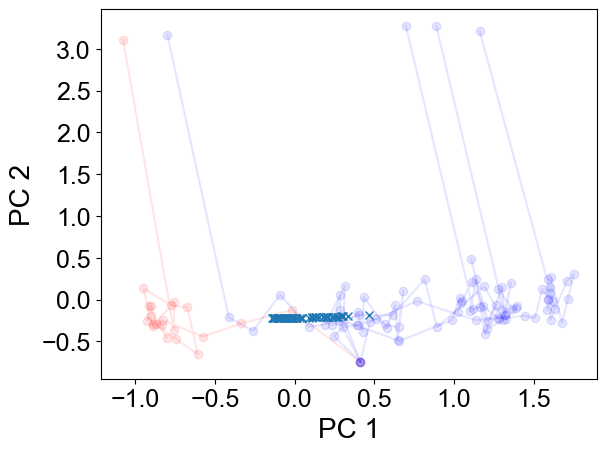

In [69]:
# Extract fixed points
fixedpoints = hidden.detach().cpu().numpy()  # Move fixed points to CPU only for plotting
print(fixedpoints.shape)

# Plot in the same space as activity
plt.figure()
for i in range(5):
    activity_pc = pca.transform(activity_dict[i])
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'
    plt.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-',
             color=color, alpha=0.1)

# Fixed points are shown in cross
fixedpoints_pc = pca.transform(fixedpoints)
plt.plot(fixedpoints_pc[:, 0], fixedpoints_pc[:, 1], 'x')
# plt.title('Fixed Points and Neural Activity in PCA Space')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('PC 1', fontsize=20)
plt.ylabel('PC 2', fontsize=20)

### Computing the Jacobian and finding the line attractor

First we will compute the Jacobian.

In [57]:
# Choose a fixed point close to the center by sorting PC1
i_fp = np.argsort(fixedpoints[:, 0])[int(fixedpoints.shape[0]/2)]

# Convert the chosen fixed point to a tensor and move it to the GPU
fp = torch.from_numpy(fixedpoints[i_fp]).to(device)
fp.requires_grad = True

# Inputs should be the 0-coherence mean input during stimulus period
# This will be task-specific; move it to the GPU
input = torch.tensor([1, 0.5, 0.5], dtype=torch.float32).to(device)
deltah = net.rnn.recurrence(input, fp) - fp

# Initialize the Jacobian matrix transpose on the GPU
jacT = torch.zeros(hidden_size, hidden_size, device=device)
for i in range(hidden_size):
    output = torch.zeros(hidden_size, device=device)  # Move output to GPU
    output[i] = 1.
    jacT[:,i] = torch.autograd.grad(deltah, fp, grad_outputs=output, retain_graph=True)[0]

# Convert the Jacobian matrix transpose back to numpy array (move to CPU for this step)
jac = jacT.detach().cpu().numpy().T

Here we plot the direction of the eigenvector corresponding to the highest eigenvalue

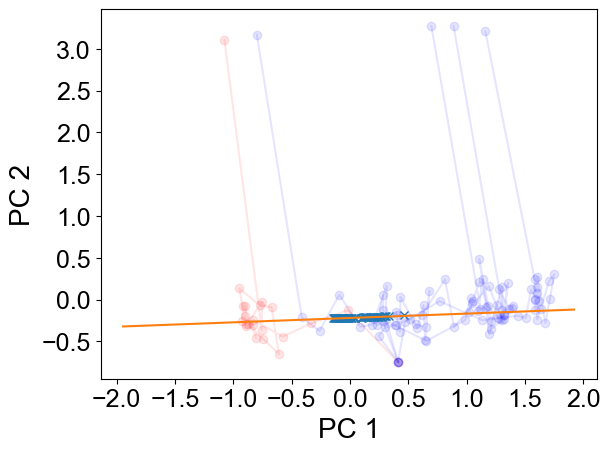

In [70]:
# Compute eigenvalues and eigenvectors
eigval, eigvec = np.linalg.eig(jac)
vec = np.real(eigvec[:, np.argmax(eigval)])
end_pts = np.array([+vec, -vec]) * 2
end_pts = pca.transform(fp.detach().cpu().numpy() + end_pts)

# Plot in the same space as activity
plt.figure()
for i in range(5):
    activity_pc = pca.transform(activity_dict[i])
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'
    plt.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color, alpha=0.1)

# Fixed points are shown in cross
fixedpoints_pc = pca.transform(fixedpoints)
plt.plot(fixedpoints_pc[:, 0], fixedpoints_pc[:, 1], 'x')

# Line attractor
plt.plot(end_pts[:, 0], end_pts[:, 1])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('PC 1', fontsize=20)
plt.ylabel('PC 2', fontsize=20)
# plt.title('Fixed Points and Activity Trajectories in PCA Space')
plt.show()

Text(0, 0.5, 'Imaginary')

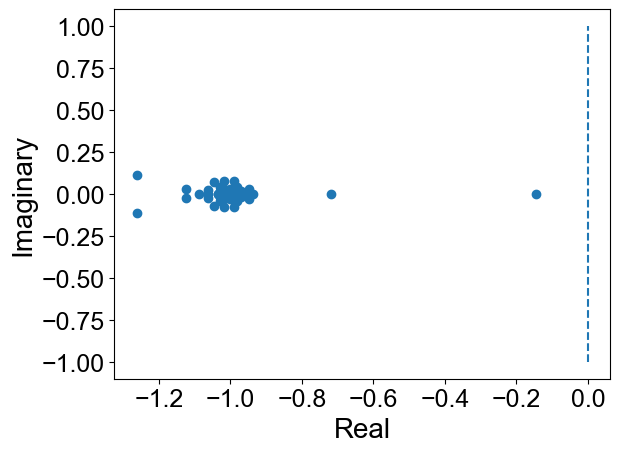

In [71]:
# Plot distribution of eigenvalues in a 2-d real-imaginary plot
plt.figure()
plt.scatter(np.real(eigval), np.imag(eigval))
plt.plot([0, 0], [-1, 1], '--')
# plt.title('Eigenvalues of the Jacobian Matrix')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Real', fontsize=20)
plt.ylabel('Imaginary', fontsize=20)